open3D no boundingbox/save

In [6]:
import numpy as np
import open3d as o3d
import pyautogui
def read_ply(filename):
    """
    Reads a PLY file containing a triangle mesh using the open3d library.

    Parameters:
    filename (str): Path to the PLY file to be read.

    Returns:
    open3d.geometry.TriangleMesh: A triangle mesh object representing the contents of the PLY file.
    """
    mesh = o3d.io.read_triangle_mesh(filename)
    return mesh

# Specify the path to the PLY file
ply_filename = "D:/aaaaaaaaaaaaaaaaa/23-24/astar/1-2data/ScanNet/scannet/scans/scene0000_00/scene0000_00_vh_clean_2.labels.ply"

# Read the PLY file and obtain a triangle mesh object
mesh = read_ply(ply_filename)

# Extract vertices and vertex colors from the mesh
vertices = np.asarray(mesh.vertices)
vertex_colors = np.asarray(mesh.vertex_colors)

# Create a new TriangleMesh object for visualization
vis_mesh = o3d.geometry.TriangleMesh()
vis_mesh.vertices = o3d.utility.Vector3dVector(vertices)
vis_mesh.triangles = o3d.utility.Vector3iVector(np.asarray(mesh.triangles))
vis_mesh.vertex_colors = o3d.utility.Vector3dVector(vertex_colors)

# Visualize the triangle mesh using open3d's visualization capabilities
o3d.visualization.draw_geometries([vis_mesh])

screenshot_images = []
for _ in range(100):  #Capture 100 frames for demo
    screenshot = pyautogui.screenshot(region=(0, 0, 800, 600))  # Adjust area to fit window size
    screenshot_images.append(screenshot)

# Save captured frames as an animated GIF image
screenshot_images[0].save("visualization_animation.gif",
                          save_all=True, append_images=screenshot_images[1:], duration=100, loop=0)
print("Visualization animation saved.")


Visualization animation saved.


VTK no boundingbox

In [22]:
import vtk

# Load the PLY file using a PLY reader
reader = vtk.vtkPLYReader()
reader.SetFileName("D:/aaaaaaaaaaaaaaaaa/23-24/astar/1-2data/ScanNet/scannet/scans/scene0000_00/scene0000_00_vh_clean_2.labels.ply")
reader.Update()

# Create a bounding box to enclose the loaded mesh
bounds = reader.GetOutput().GetBounds()
bounding_box = vtk.vtkCubeSource()
bounding_box.SetBounds(bounds)

# Set up visualization components
mapper = vtk.vtkPolyDataMapper()
mapper.SetInputConnection(reader.GetOutputPort())

actor = vtk.vtkActor()
actor.SetMapper(mapper)

bounding_box_mapper = vtk.vtkPolyDataMapper()
bounding_box_mapper.SetInputConnection(bounding_box.GetOutputPort())

bounding_box_actor = vtk.vtkActor()
bounding_box_actor.SetMapper(bounding_box_mapper)
bounding_box_actor.GetProperty().SetColor(1, 1, 1)  # Set bounding box color to white
bounding_box_actor.GetProperty().SetRepresentationToWireframe()  # Display bounding box as wireframe

# Create a renderer and add actors to it
renderer = vtk.vtkRenderer()
renderer.AddActor(actor)
renderer.AddActor(bounding_box_actor)

# Create a render window and attach the renderer to it
renderWindow = vtk.vtkRenderWindow()
renderWindow.AddRenderer(renderer)

# Set up a render window interactor for user interaction
renderWindowInteractor = vtk.vtkRenderWindowInteractor()
renderWindowInteractor.SetRenderWindow(renderWindow)

# Render the scene and start the interaction
renderWindow.Render()
renderWindowInteractor.Start()


vtk only for label information in ply

In [23]:
import vtk
import plyfile
import numpy as np

# Specify the path to your PLY file
ply_file_path = "D:/aaaaaaaaaaaaaaaaa/23-24/astar/1-2data/ScanNet/scannet/scans/scene0000_00/scene0000_00_vh_clean_2.labels.ply"

# Open the PLY file for reading
with open(ply_file_path, "rb") as ply_file:
    # Read the PLY file using plyfile library
    plydata = plyfile.PlyData.read(ply_file)

# Extract vertex, label, and color arrays
vertices = np.vstack([
    plydata["vertex"]["x"],
    plydata["vertex"]["y"],
    plydata["vertex"]["z"]
]).T

labels = plydata["vertex"]["label"]

red = plydata["vertex"]["red"] / 255.0
green = plydata["vertex"]["green"] / 255.0
blue = plydata["vertex"]["blue"] / 255.0

# Specify the label for the desired bounding box
selected_label = 16  # Change this to the label you want to visualize

# Get the indices of points with the selected label
selected_indices = np.where(labels == selected_label)[0]

if len(selected_indices) == 0:
    print(f"No points found with label {selected_label}.")
else:
    selected_points = vertices[selected_indices]

    # Calculate the minimum and maximum coordinates for the bounding box
    min_coords = np.min(selected_points, axis=0)
    max_coords = np.max(selected_points, axis=0)

    # Create the eight corner points of the bounding box
    corners = [
        [min_coords[0], min_coords[1], min_coords[2]],
        [max_coords[0], min_coords[1], min_coords[2]],
        [max_coords[0], max_coords[1], min_coords[2]],
        [min_coords[0], max_coords[1], min_coords[2]],
        [min_coords[0], min_coords[1], max_coords[2]],
        [max_coords[0], min_coords[1], max_coords[2]],
        [max_coords[0], max_coords[1], max_coords[2]],
        [min_coords[0], max_coords[1], max_coords[2]]
    ]

    # Create vtkPoints for the bounding box corners
    vtk_corners = vtk.vtkPoints()
    for corner in corners:
        vtk_corners.InsertNextPoint(corner)

    # Create a vtkCellArray to store the lines
    lines = vtk.vtkCellArray()
    line_indices = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Bottom edges
        [4, 5], [5, 6], [6, 7], [7, 4],  # Top edges
        [0, 4], [1, 5], [2, 6], [3, 7]   # Vertical edges
    ]
    for indices in line_indices:
        lines.InsertNextCell(2)
        lines.InsertCellPoint(indices[0])
        lines.InsertCellPoint(indices[1])

    # Create a vtkPolyData object for the bounding box lines
    bounding_box_polydata = vtk.vtkPolyData()
    bounding_box_polydata.SetPoints(vtk_corners)
    bounding_box_polydata.SetLines(lines)

    # Create a mapper and actor for the bounding box lines
    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputData(bounding_box_polydata)

    actor = vtk.vtkActor()
    actor.SetMapper(mapper)
    actor.GetProperty().SetColor(1, 0, 0)  # Red color for the bounding box lines

    # Create a vtkPoints object for the entire point cloud
    vtk_points = vtk.vtkPoints()
    for vertex in vertices:
        vtk_points.InsertNextPoint(vertex)

    # Create a vtkCellArray to store the vertices
    cloud_verts = vtk.vtkCellArray()
    for i in range(len(vertices)):
        cloud_verts.InsertNextCell(1)
        cloud_verts.InsertCellPoint(i)

    # Create a vtkUnsignedCharArray for colors based on the ply data
    colors = vtk.vtkUnsignedCharArray()
    colors.SetNumberOfComponents(3)
    colors.SetName("Colors")

    for r, g, b in zip(red, green, blue):
        colors.InsertNextTuple3(int(r * 255), int(g * 255), int(b * 255))

    # Create a vtkPolyData object for the entire point cloud
    point_cloud = vtk.vtkPolyData()
    point_cloud.SetPoints(vtk_points)
    point_cloud.SetVerts(cloud_verts)
    point_cloud.GetPointData().SetScalars(colors)

    # Create a mapper and actor for the point cloud
    cloud_mapper = vtk.vtkPolyDataMapper()
    cloud_mapper.SetInputData(point_cloud)

    cloud_actor = vtk.vtkActor()
    cloud_actor.SetMapper(cloud_mapper)

    # Create a renderer and add actors to it
    renderer = vtk.vtkRenderer()
    renderer.AddActor(cloud_actor)
    renderer.AddActor(actor)

    # Create a render window and add the renderer to it
    render_window = vtk.vtkRenderWindow()
    render_window.AddRenderer(renderer)

    # Create a render window interactor
    render_window_interactor = vtk.vtkRenderWindowInteractor()
    render_window_interactor.SetRenderWindow(render_window)

    # Render the scene
    render_window.Render()
    render_window_interactor.Start()




vtk for label information in ply and json( No corrections are made for coordinate system offsets)

In [24]:
import vtk
import plyfile
import json
import numpy as np

# Load the first JSON file with aggregation information
aggregation_file_path = "D:/aaaaaaaaaaaaaaaaa/23-24/astar/1-2data/ScanNet/scannet/scans/scene0000_00/scene0000_00.aggregation.json"
with open(aggregation_file_path, "r") as aggregation_file:
    aggregation_data = json.load(aggregation_file)

# Load the second JSON file with segmentation information
segmentation_file_path = "D:/aaaaaaaaaaaaaaaaa/23-24/astar/1-2data/ScanNet/scannet/scans/scene0000_00/scene0000_00_vh_clean_2.0.010000.segs.json"
with open(segmentation_file_path, "r") as segmentation_file:
    segmentation_data = json.load(segmentation_file)

user_label = input("Enter a label: ")

In [25]:
import vtk
import plyfile
import json
import numpy as np

# Load the first JSON file with aggregation information
aggregation_file_path = "D:/aaaaaaaaaaaaaaaaa/23-24/astar/1-2data/ScanNet/scannet/scans/scene0000_00/scene0000_00.aggregation.json"
with open(aggregation_file_path, "r") as aggregation_file:
    aggregation_data = json.load(aggregation_file)

# Load the second JSON file with segmentation information
segmentation_file_path = "D:/aaaaaaaaaaaaaaaaa/23-24/astar/1-2data/ScanNet/scannet/scans/scene0000_00/scene0000_00_vh_clean_2.0.010000.segs.json"
with open(segmentation_file_path, "r") as segmentation_file:
    segmentation_data = json.load(segmentation_file)

user_label = input("Enter a label: ")

# Find matching segments based on user input label
matching_segments_dict = {}

for seg_group in aggregation_data["segGroups"]:
    if seg_group["label"] == user_label:
        seg_id = seg_group["id"]
        if seg_id not in matching_segments_dict:
            matching_segments_dict[seg_id] = []
        matching_segments_dict[seg_id].extend(seg_group["segments"])

# Extract the matching segment from the dictionary as a two-dimensional list
matching_segments = list(matching_segments_dict.values())

print(matching_segments)

matching_indices_dict = {}  # Use a dictionary to store matching indices for different seg_group["id"]
segmentation_data = np.array(segmentation_data["segIndices"])
seg_group_id = -1
# Loop through each matching segment
for seg_group in matching_segments:
    seg_group_id = seg_group_id + 1
    for matching_segment in seg_group:
        positions = np.where(segmentation_data == matching_segment)[0]
        if seg_group_id not in matching_indices_dict:
            matching_indices_dict[seg_group_id] = []
        matching_indices_dict[seg_group_id].extend(positions.tolist())
        
# Load the PLY file
ply_file_path = "D:/aaaaaaaaaaaaaaaaa/23-24/astar/1-2data/ScanNet/scannet/scans/scene0000_00/scene0000_00_vh_clean_2.labels.ply"
with open(ply_file_path, "rb") as ply_file:
    plydata = plyfile.PlyData.read(ply_file)

vertices = np.vstack([
    plydata["vertex"]["x"],
    plydata["vertex"]["y"],
    plydata["vertex"]["z"]
]).T

# Extract the coordinates of matching points
# matching_points = vertices[matching_indices]
matching_points = vertices[matching_indices_dict[0]]
# print(matching_points)

[[43652, 43832, 43632, 53294, 44062, 44013, 44158, 53070, 53173, 53253], [77796, 77832, 78722]]


In [20]:
matching_points

array([[3.8378706, 8.08761  , 1.8599916],
       [3.8386903, 8.085124 , 1.9185367],
       [3.930875 , 8.084579 , 1.6982304],
       ...,
       [4.5955105, 8.377085 , 2.0018563],
       [4.647142 , 8.337653 , 2.0497363],
       [4.598997 , 8.37756  , 1.9550947]], dtype=float32)

In [28]:
import vtk
import numpy as np

# Access label information from plydata
labels = plydata["vertex"]["label"]

# Normalize RGB color values to the range [0, 1]
red = plydata["vertex"]["red"] / 255.0
green = plydata["vertex"]["green"] / 255.0
blue = plydata["vertex"]["blue"] / 255.0

# Create VTK points to store vertex coordinates
vtk_points = vtk.vtkPoints()
for vertex in vertices:
    vtk_points.InsertNextPoint(vertex)

# Create VTK cell array for the point cloud
cloud_verts = vtk.vtkCellArray()
for i in range(len(vertices)):
    cloud_verts.InsertNextCell(1)
    cloud_verts.InsertCellPoint(i)

# Create VTK colors array for RGB vertex colors
colors = vtk.vtkUnsignedCharArray()
colors.SetNumberOfComponents(3)
colors.SetName("Colors")

# Populate colors array with RGB tuples
for r, g, b in zip(red, green, blue):
    colors.InsertNextTuple3(int(r * 255), int(g * 255), int(b * 255))

# Create VTK PolyData for the point cloud
point_cloud = vtk.vtkPolyData()
point_cloud.SetPoints(vtk_points)
point_cloud.SetVerts(cloud_verts)
point_cloud.GetPointData().SetScalars(colors)

# Create VTK PolyDataMapper for the point cloud
cloud_mapper = vtk.vtkPolyDataMapper()
cloud_mapper.SetInputData(point_cloud)

# Create VTK Actor for the point cloud
cloud_actor = vtk.vtkActor()
cloud_actor.SetMapper(cloud_mapper)

# Create a VTK renderer
renderer = vtk.vtkRenderer()
renderer.AddActor(cloud_actor)

# Iterate over each segment group to create bounding boxes and add to renderer
for seg_group_id in matching_indices_dict:
    matching_points = vertices[matching_indices_dict[seg_group_id]]

    # Calculate the minimum and maximum coordinates for the bounding box
    min_coords = np.min(matching_points, axis=0)
    max_coords = np.max(matching_points, axis=0)

    # Define bounding box corners
    corners = [
        [min_coords[0], min_coords[1], min_coords[2]],
        [max_coords[0], min_coords[1], min_coords[2]],
        [max_coords[0], max_coords[1], min_coords[2]],
        [min_coords[0], max_coords[1], min_coords[2]],
        [min_coords[0], min_coords[1], max_coords[2]],
        [max_coords[0], min_coords[1], max_coords[2]],
        [max_coords[0], max_coords[1], max_coords[2]],
        [min_coords[0], max_coords[1], max_coords[2]]
    ]

    # Create VTK Points for bounding box corners
    vtk_corners = vtk.vtkPoints()
    for corner in corners:
        vtk_corners.InsertNextPoint(corner)
    lines = vtk.vtkCellArray()
    # Define line indices for bounding box edges
    line_indices = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Bottom edges
        [4, 5], [5, 6], [6, 7], [7, 4],  # Top edges
        [0, 4], [1, 5], [2, 6], [3, 7]   # Vertical edges
    ]
    # Create VTK CellArray for bounding box lines
    for indices in line_indices:
        lines.InsertNextCell(2)
        lines.InsertCellPoint(indices[0])
        lines.InsertCellPoint(indices[1])

    # Create a vtkPolyData object for the bounding box lines
    bounding_box_polydata = vtk.vtkPolyData()
    bounding_box_polydata.SetPoints(vtk_corners)
    bounding_box_polydata.SetLines(lines)

    # Create VTK PolyDataMapper for bounding box
    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputData(bounding_box_polydata)

    # Create VTK Actor for bounding box
    actor = vtk.vtkActor()
    actor.SetMapper(mapper)
    actor.GetProperty().SetColor(1, 0, 0)  # # Set bounding box color to red

    renderer.AddActor(actor)

# Create label text and add to renderer
label_text = vtk.vtkTextActor()
label_text.GetTextProperty().SetFontSize(18)
label_text.GetTextProperty().SetColor(1.0, 1.0, 1.0)  # Set text color to white

label_text.SetInput(user_label)   # Set text content

# Set text alignment
label_text.GetTextProperty().SetVerticalJustificationToBottom()
label_text.GetTextProperty().SetJustificationToLeft()

label_text_position = (min_coords + max_coords) / 2  # Place label at bounding box center
label_text_position[2] = max_coords[2]  # Raise slightly along Z-axis to avoid occlusion
label_text_position[1] -= 0.05 * (max_coords[1] - min_coords[1])  # Adjust Y position

label_text.SetPosition(label_text_position[0], label_text_position[1])
renderer.AddActor2D(label_text)

# Create a VTK render window
render_window = vtk.vtkRenderWindow()
render_window.AddRenderer(renderer)

# Create a VTK render window interactor
render_window_interactor = vtk.vtkRenderWindowInteractor()
render_window_interactor.SetRenderWindow(render_window)

# Render the scene
render_window.Render()

# Start interaction
render_window_interactor.Start()

ply after using the corrected coordinate system

In [40]:
import vtk
import plyfile
import json
import numpy as np

# Load the first JSON file with aggregation information
aggregation_file_path = "D:/aaaaaaaaaaaaaaaaa/23-24/astar/1-2data/ScanNet/scannet/scans/scene0000_00/scene0000_00.aggregation.json"
with open(aggregation_file_path, "r") as aggregation_file:
    aggregation_data = json.load(aggregation_file)

# Load the second JSON file with segmentation information
segmentation_file_path = "D:/aaaaaaaaaaaaaaaaa/23-24/astar/1-2data/ScanNet/scannet/scans/scene0000_00/scene0000_00_vh_clean_2.0.010000.segs.json"
with open(segmentation_file_path, "r") as segmentation_file:
    segmentation_data = json.load(segmentation_file)

# Prompt user for a label
user_label = input("Enter a label: ")

# Find matching segments based on user input label
matching_segments_dict = {}

for seg_group in aggregation_data["segGroups"]:
    if seg_group["label"] == user_label:
        seg_id = seg_group["id"]
        if seg_id not in matching_segments_dict:
            matching_segments_dict[seg_id] = []
        matching_segments_dict[seg_id].extend(seg_group["segments"])

# Extract matching segments from the dictionary into a 2D list
matching_segments = list(matching_segments_dict.values())

print(matching_segments)

matching_indices_dict = {}  # Dictionary to store matching indices for different seg_group["id"]
segmentation_data = np.array(segmentation_data["segIndices"])
seg_group_id = -1
# Loop through each matching segment
for seg_group in matching_segments:
    seg_group_id = seg_group_id + 1
    for matching_segment in seg_group:
        positions = np.where(segmentation_data == matching_segment)[0]
        if seg_group_id not in matching_indices_dict:
            matching_indices_dict[seg_group_id] = []
        matching_indices_dict[seg_group_id].extend(positions.tolist())
        
# Load the PLY file
# ply_file_path = "D:/aaaaaaaaaaaaaaaaa/23-24/astar/1-2data/ScanNet/scannet/scans/scene0000_00/scene0000_00_vh_clean_2.labels.ply"
ply_file_path = "./aligned_mesh2.ply"
with open(ply_file_path, "rb") as ply_file:
    plydata = plyfile.PlyData.read(ply_file)

# Extract vertex coordinates from PLY data
vertices = np.vstack([
    plydata["vertex"]["x"],
    plydata["vertex"]["y"],
    plydata["vertex"]["z"]
]).T

# Extract the coordinates of matching points
# matching_points = vertices[matching_indices]
matching_points = vertices[matching_indices_dict[0]]
# print(matching_points)


[[17909, 3376, 3849, 4241, 273, 17737, 3454, 1015, 3703, 4603, 3441, 3449, 3295, 3137, 4080, 6708, 4886, 4421, 4046, 4029, 4680, 4754, 7611, 7586, 6660, 687, 7659, 768, 7059, 7046, 1465, 49, 1067, 5753, 5778, 6574, 6778, 5004, 5242, 7163, 16897], [34411, 34769, 23667, 34893, 23501, 34142, 34809, 33377, 33157, 34470, 23885, 33455, 23627, 23486, 23127, 23165, 22863, 22812, 23894]]


In [41]:
import vtk
import numpy as np

# Load the PLY file using vtkPLYReader
reader = vtk.vtkPLYReader()
# reader.SetFileName("D:/aaaaaaaaaaaaaaaaa/23-24/astar/1-2data/ScanNet/scannet/scans/scene0000_00/scene0000_00_vh_clean_2.labels.ply")
reader.SetFileName("./aligned_mesh1.ply")
reader.Update()

# Access label information from plydata
labels = plydata["vertex"]["label"]

# Normalize RGB color values to the range [0, 1]
red = plydata["vertex"]["red"] / 255.0
green = plydata["vertex"]["green"] / 255.0
blue = plydata["vertex"]["blue"] / 255.0

# Create VTK points to store vertex coordinates
vtk_points = vtk.vtkPoints()
for vertex in vertices:
    vtk_points.InsertNextPoint(vertex)

# Create VTK cell array for the point cloud
cloud_verts = vtk.vtkCellArray()
for i in range(len(vertices)):
    cloud_verts.InsertNextCell(1)
    cloud_verts.InsertCellPoint(i)

# Create VTK colors array for RGB vertex colors
colors = vtk.vtkUnsignedCharArray()
colors.SetNumberOfComponents(3)
colors.SetName("Colors")

# Populate colors array with RGB tuples
for r, g, b in zip(red, green, blue):
    colors.InsertNextTuple3(int(r * 255), int(g * 255), int(b * 255))

# Create VTK PolyData for the point cloud
point_cloud = vtk.vtkPolyData()
point_cloud.SetPoints(vtk_points)
point_cloud.SetVerts(cloud_verts)
point_cloud.GetPointData().SetScalars(colors)

# Create VTK PolyDataMapper for the point cloud
cloud_mapper = vtk.vtkPolyDataMapper()
cloud_mapper.SetInputData(point_cloud)

# Create VTK Actor for the point cloud
cloud_actor = vtk.vtkActor()
cloud_actor.SetMapper(cloud_mapper)

# Create a VTK renderer
renderer = vtk.vtkRenderer()

# Create a bounding box for the mesh
bounds = reader.GetOutput().GetBounds()
bounding_box = vtk.vtkCubeSource()
bounding_box.SetBounds(bounds)

# Create a PolyDataMapper and Actor for the mesh
mesh_mapper = vtk.vtkPolyDataMapper()
mesh_mapper.SetInputConnection(reader.GetOutputPort())

mesh_actor = vtk.vtkActor()
mesh_actor.SetMapper(mesh_mapper)

# Create a PolyDataMapper and Actor for the bounding box
bounding_box_mapper = vtk.vtkPolyDataMapper()
bounding_box_mapper.SetInputConnection(bounding_box.GetOutputPort())

bounding_box_actor = vtk.vtkActor()
bounding_box_actor.SetMapper(bounding_box_mapper)
bounding_box_actor.GetProperty().SetColor(1, 1, 1)
bounding_box_actor.GetProperty().SetRepresentationToWireframe()

# Add mesh, bounding box, and point cloud actors to the renderer
renderer.AddActor(mesh_actor)
renderer.AddActor(bounding_box_actor)
renderer.AddActor(cloud_actor)

# Loop through each matching segment group, create bounding boxes, and add to renderer
for seg_group_id in matching_indices_dict:
    matching_points = vertices[matching_indices_dict[seg_group_id]]

    # Calculate the minimum and maximum coordinates for the bounding box
    min_coords = np.min(matching_points, axis=0)
    max_coords = np.max(matching_points, axis=0)

    # Define the corners of the bounding box
    corners = [
        [min_coords[0], min_coords[1], min_coords[2]],
        [max_coords[0], min_coords[1], min_coords[2]],
        [max_coords[0], max_coords[1], min_coords[2]],
        [min_coords[0], max_coords[1], min_coords[2]],
        [min_coords[0], min_coords[1], max_coords[2]],
        [max_coords[0], min_coords[1], max_coords[2]],
        [max_coords[0], max_coords[1], max_coords[2]],
        [min_coords[0], max_coords[1], max_coords[2]]
    ]

    # Create VTK Points for bounding box corners
    vtk_corners = vtk.vtkPoints()
    for corner in corners:
        vtk_corners.InsertNextPoint(corner)
    
    # Define line indices for bounding box edges
    line_indices = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Bottom edges
        [4, 5], [5, 6], [6, 7], [7, 4],  # Top edges
        [0, 4], [1, 5], [2, 6], [3, 7]   # Vertical edges
    ]

    # Create VTK CellArray for bounding box lines
    lines = vtk.vtkCellArray()
    for indices in line_indices:
        lines.InsertNextCell(2)
        lines.InsertCellPoint(indices[0])
        lines.InsertCellPoint(indices[1])

    # Create VTK PolyData for bounding box lines
    bounding_box_polydata = vtk.vtkPolyData()
    bounding_box_polydata.SetPoints(vtk_corners)
    bounding_box_polydata.SetLines(lines)

    # Create a VTK PolyDataMapper and Actor for the bounding box
    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputData(bounding_box_polydata)

    actor = vtk.vtkActor()
    actor.SetMapper(mapper)
    actor.GetProperty().SetColor(1, 0, 0)  # Set bounding box color to red

    renderer.AddActor(actor)

# Create text actor for labels and add to renderer
label_text = vtk.vtkTextActor()
label_text.GetTextProperty().SetFontSize(28)
label_text.GetTextProperty().SetColor(1.0, 1.0, 1.0)  # Set text color to white

label_text.SetInput(user_label)  # Set text content

# Set text alignment properties
label_text.GetTextProperty().SetVerticalJustificationToBottom()
label_text.GetTextProperty().SetJustificationToLeft()

# Calculate label text position and adjust Z-axis to avoid occlusion
label_text_position = (min_coords + max_coords) / 2 
label_text_position[2] = max_coords[2] 
label_text_position[1] -= 0.05 * (max_coords[1] - min_coords[1]) 

label_text.SetPosition(label_text_position[0], label_text_position[1])
renderer.AddActor2D(label_text)

# Create a VTK render window
render_window = vtk.vtkRenderWindow()
render_window.AddRenderer(renderer)

# Create a VTK render window interactor
render_window_interactor = vtk.vtkRenderWindowInteractor()
render_window_interactor.SetRenderWindow(render_window)

# Render the scene
render_window.Render()

# Start interaction
render_window_interactor.Start()


In [38]:
labels_array = reader.GetOutput().GetPointData().GetArray("RGBA")
print(labels_array)

vtkUnsignedCharArray (000001B95BA7A250)
  Debug: Off
  Modified Time: 3053426
  Reference Count: 3
  Registered Events: (none)
  Name: RGBA
  Data type: unsigned char
  Size: 325476
  MaxId: 325475
  NumberOfComponents: 4
  Information: 000001B968A66BF0
    Debug: Off
    Modified Time: 3363497
    Reference Count: 1
    Registered Events: (none)
    PER_COMPONENT: vtkInformationVector(000001B968A66020)
  Name: RGBA
  Number Of Components: 4
  Number Of Tuples: 81369
  Size: 325476
  MaxId: 325475
  LookupTable: (none)




In [25]:
print(plydata["vertex"])
print(plydata["vertex"]["label"])
print(plydata["vertex"][8800])

element vertex 81369
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
property uchar alpha
property ushort label
[16 16 16 ...  1  1  1]
(0.890824, 5.3611965, 1.1560187, 31, 119, 180, 253, 3)


2d image visualization

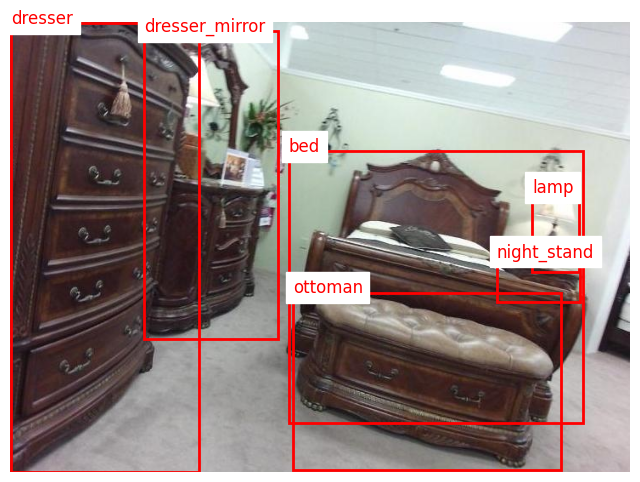

In [39]:
import cv2
import matplotlib.pyplot as plt

# Path to the image file
image_path = "D:/aaaaaaaaaaaaaaaaa/23-24/astar/1-2data/sess-master/sess-master/sunrgbd/sunrgbd_trainval/image/000001.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')

# Path to the label file
label_path = "D:/aaaaaaaaaaaaaaaaa/23-24/astar/1-2data/sess-master/sess-master/sunrgbd/sunrgbd_trainval/label/000001.txt"

# Read and process the label file
with open(label_path, 'r') as file:
    lines = file.readlines()
    for line in lines:
        parts = line.strip().split()
        classname = parts[0]
        box2d = list(map(float, parts[1:5]))
        centroid = list(map(float, parts[5:8]))
        coeffs = list(map(float, parts[8:11]))
        orientation = list(map(float, parts[11:]))

        x, y, w, h = box2d
        # Add bounding box rectangle to the image
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2))
        
        # Add classname as text near the bounding box
        plt.text(x, y, classname, color='red', backgroundcolor='white', fontsize=12)

# Show the image with bounding boxes and labels
plt.show()

